In [1]:
#Import packages

import numpy as np
from numpy.typing import NDArray
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

#Auxiliary functions

def add_noise_to_feature(X, feature_index=0, noise_level=0.1):
    """
    Add Gaussian noise to a specific feature in the dataset.

    Args:
    - X: Feature matrix (numpy array).
    - feature_index: Index of the feature to add noise to.
    - noise_level: Standard deviation of the noise to add.

    Returns:
    - X_noisy: Feature matrix with noise added to the specified feature.
    """
    X_noisy = X.copy()
    noise = np.random.normal(0, noise_level, size=X_noisy[:, feature_index].shape)
    X_noisy[:, feature_index] += noise
    return X_noisy

def create_sliding_windows(data, labels, window_size, step=1):
    X_windows = []
    y_windows = []
    for i in range(0, len(data) - window_size + 1, step):
        X_windows.append(data[i:i + window_size].flatten())  # Flatten for RF compatibility
        y_windows.append(labels[i + window_size - 1])  # Label is the last element in the window
    return np.array(X_windows), np.array(y_windows)

def onehot2cat(y:NDArray) -> NDArray:
    '''Convert y in one_hot to categorical'''
    return np.argmax(y, axis=1) 


def loadDataset(fn:str, toCat:bool=False) -> NDArray:
    '''load dataset'''
    with open(fn, 'rb') as f:
        data = pickle.load(f)
        
    X = data['X'] 
    if toCat: y = onehot2cat(data['Y'])
    else:     y = data['Y'] 
    
    return X, y

def saveSKLModel(fn:str, model) -> None:
    '''save SKLearn model as pickle'''
    with open(fn, 'wb') as f:
        pickle.dump(model, f)

#load dataset

fnt = 'wtdt-part.pickle'
X, y = loadDataset(fnt, toCat=True)

with open("wdt-train.pickle", "rb") as f:
    train_data = pickle.load(f)
X_train = train_data['X']
y_train = train_data['y']
X_train.shape

# Load the test dataset (400 samples per class)
with open("wdt-test-perturbed.pickle", "rb") as f:
    test_data = pickle.load(f)
X_test = test_data['X']
y_test = test_data['y']


In [117]:
model = LogisticRegression(C=1e10, penalty= 'l1', solver='liblinear', max_iter=5)
model.fit(X,y)
saveSKLModel("T1-LogisticRegression.pickle", model)

c:\Users\diogo\Documents\GitHub\AM\venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Overall Test Accuracy: 0.8594

Accuracy per Fault Class:
Fault Class 0: 0.0080
Fault Class 1: 0.9950
Fault Class 2: 0.9950
Fault Class 3: 0.9975
Fault Class 4: 0.9875
Fault Class 5: 0.9775
Fault Class 6: 1.0000


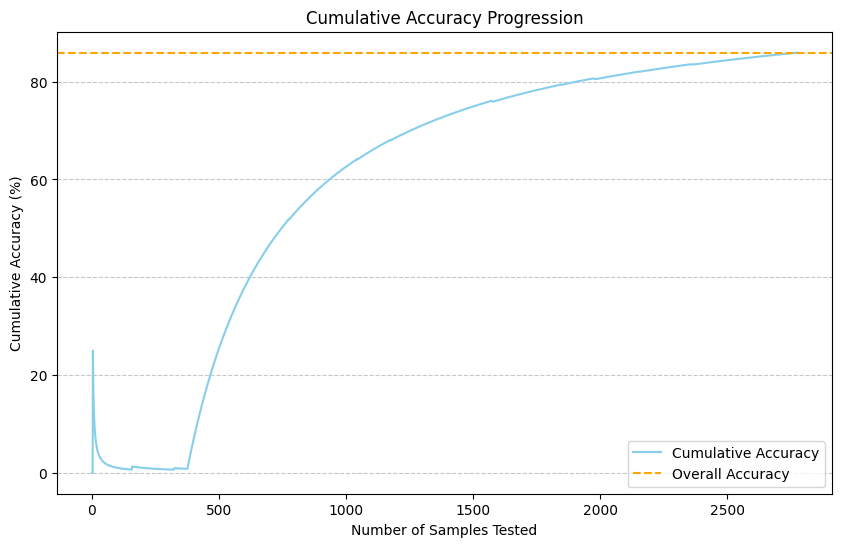

In [6]:
window_size = 27
step = 1  

def create_sliding_windows(data, labels, window_size, step=1):
    X_windows = []
    y_windows = []
    for i in range(0, len(data) - window_size + 1, step):
        X_windows.append(data[i:i + window_size].flatten())
        y_windows.append(labels[i + window_size - 1]) 
    return np.array(X_windows), np.array(y_windows)


X_train_windows, y_train_windows = create_sliding_windows(X_train, y_train, window_size)
X_test_windows, y_test_windows = create_sliding_windows(X_test, y_test, window_size)


model = RandomForestClassifier(
    n_estimators=15,
    criterion='log_loss',
    max_depth=357,
    min_samples_split=100,
    min_samples_leaf=50,
    min_weight_fraction_leaf=0.10709307513026126,
    max_features=None,
    max_leaf_nodes=250,
    min_impurity_decrease=0.03817694161094444,
    bootstrap=True,
    oob_score=False,
    class_weight=None,
    ccp_alpha=0.0038992679969999692,
    max_samples=0.4114388666495566
)

model.fit(X_train_windows, y_train_windows)

y_pred = model.predict(X_test_windows)

overall_accuracy = accuracy_score(y_test_windows, y_pred)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

# Accuracy per fault class (use y_test_windows instead of y_test)
print("\nAccuracy per Fault Class:")
for fault_class in range(7):  # Assuming 7 fault classes (0–6)
    class_indices = np.where(y_test_windows == fault_class)[0]
    y_true_class = y_test_windows[class_indices]
    y_pred_class = y_pred[class_indices]

    # Compute accuracy for the current fault class
    if len(y_true_class) > 0:  # Avoid division by zero
        class_accuracy = accuracy_score(y_true_class, y_pred_class)
        print(f"Fault Class {fault_class}: {class_accuracy:.4f}")
    else:
        print(f"Fault Class {fault_class}: No samples in this class")

# Generate indices for cumulative accuracy calculation
indices = np.arange(len(y_test_windows))  # Based on sliding windows test labels

# Initialize variables to track cumulative accuracy
cumulative_correct = 0
cumulative_accuracies = []

# Compute cumulative accuracy
for i, index in enumerate(indices):
    # Check if the current prediction is correct
    if y_pred[index] == y_test_windows[index]:
        cumulative_correct += 1

    # Calculate cumulative accuracy
    cumulative_accuracy = (cumulative_correct / (i + 1)) * 100
    cumulative_accuracies.append(cumulative_accuracy)

# Plotting cumulative accuracy progression
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_accuracies) + 1), cumulative_accuracies, label="Cumulative Accuracy", color="skyblue")
plt.axhline(y=accuracy_score(y_test_windows, y_pred) * 100, color='orange', linestyle='--', label="Overall Accuracy")
plt.xlabel("Number of Samples Tested")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy Progression")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


saveSKLModel("T1-randomForest.pickle", model)

In [57]:
start_index = 0
end_index = 1600
X = X_train[start_index:end_index]
y = y_train[start_index:end_index]

# Train a model (e.g., Random Forest) on fault class 1
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

In [79]:
X_subset = []
y_subset = []

# Fault class 0: Keep all 1600 samples
mask_class_0 = (y_train == 0)
X_subset.append(X_train[mask_class_0][:1600])
y_subset.append(y_train[mask_class_0][:1600])

# Fault classes 1 to 6: Take 800 samples from each
for fault_class in range(1, 7):
    mask = (y_train == fault_class)
    X_subset.append(X_train[mask][:1])
    y_subset.append(y_train[mask][:1])

# Combine the subsets
X_balanced = np.vstack(X_subset)
y_balanced = np.hstack(y_subset)

print("Balanced dataset shape:")
print("X_balanced:", X_balanced.shape)
print("y_balanced:", y_balanced.shape)

# Shuffle the dataset to ensure randomness
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_balanced, y_balanced)


Balanced dataset shape:
X_balanced: (1606, 787)
y_balanced: (1606,)


RandomForestClassifier(random_state=42)

In [86]:
model_weights = {0: 1.0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [85]:
# Predict using the trained model
y_pred = model.predict(X_test)

# Overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

# Accuracy for each fault class
print("\nAccuracy per Fault Class:")
for fault_class in range(7):  # Assuming 7 fault classes (0–6)
    # Extract samples belonging to the current fault class
    class_indices = np.where(y_test == fault_class)[0]
    y_true_class = y_test[class_indices]
    y_pred_class = y_pred[class_indices]

    # Compute accuracy for the current fault class
    class_accuracy = accuracy_score(y_true_class, y_pred_class)
    print(f"Fault Class {fault_class}: {class_accuracy:.4f}")


ValueError: X has 787 features, but RandomForestClassifier is expecting 7870 features as input.

In [93]:
# Sort the test samples by indices (or randomize for more variability if needed)
indices = np.arange(len(y_test))

# Initialize variables to track cumulative accuracy
cumulative_correct = 0
cumulative_accuracies = []

# Compute cumulative accuracy
for i, index in enumerate(indices):
    # Check if the current prediction is correct
    if y_pred[index] == y_test[index]:
        cumulative_correct += 1

    # Calculate cumulative accuracy
    cumulative_accuracy = (cumulative_correct / (i + 1)) * 100
    cumulative_accuracies.append(cumulative_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_accuracies) + 1), cumulative_accuracies, label="Cumulative Accuracy", color="skyblue")
plt.axhline(y=accuracy_score(y_test, y_pred) * 100, color='orange', linestyle='--', label="Overall Accuracy")
plt.xlabel("Number of Samples Tested")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy Progression")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


IndexError: index 2790 is out of bounds for axis 0 with size 2790